In [1]:
import numpy as np
from decimal import *
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from dzigzag_class import dz_sampler
from dcoordinate_class import dc_sampler
sns.set()


@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)


# Set necessary precision for lattice gaussians
getcontext().prec = 100

Our goal is to use the dPDMP sampler for lattice Gaussians - Gaussians defined on the lattice $X = \mathbb{Z}^n$, for $n \in \mathbb N$. In this case our generators are quite simple. Consider $\mathbf x \in X$ and some $1 \leq i \leq n$. In this case, the generator $v_i^\tau, \tau \in \{-1,1 \}$ acts on $x$ by
\begin{equation}
v_i^\tau \mathbf x = \mathbf x + e_i \tau,
\end{equation}
where $e_i$ is the i'th unit-vector, i.e. it adds $\tau$ to the i'th coordinate of $x$. Our target in this case is given by
\begin{equation}
\rho_{s,c}(\mathbf x) \propto \exp \Big \{ - \frac{\pi \Vert \mathbf x - c \Vert_2^2}{s^2}\Big \}.
\end{equation}
For the BLISS model of Durmus et al., it turns out that $c = 0$, and furthermore that $s > 268$.

To run the dPDMP, we need to calculate the rates. Consider a locally balancing function $g$, we need 
\begin{equation}
g\Big (\frac{\rho_{s,c}( v_i^\tau \mathbf x)}{\rho_{s,c}(\mathbf x)} \Big ) = g\Big ( \Big )
\end{equation}

In [3]:
n = 3
s = Decimal(500)
deci_pi = Decimal(np.pi)
variance_constant = deci_pi/s**2
t_val = 0.5

def balancing_function(x):
    return Decimal(x/(1+x))

def discrete_gaussian(x):
    norm_vec = Decimal(0)
    for i in range(n):
        norm_vec += x[i]**2
    return Decimal(-variance_constant * norm_vec).exp()

def energy_function(x):
    return 

def apply_gen(x, gen_id, theta):
    y = x.copy()
    y[gen_id] = x[gen_id] + theta[gen_id]
    return y

def calculate_rates(x, theta, jump_rates=0, gen_id=0):
    forward_rates = []
    backward_rates = []
    
    theta_inverse = [val*-1 for val in theta]
    
    base_prop = discrete_gaussian(x)
    
    for i in range(n):
        forward_prop = discrete_gaussian(apply_gen(x, i, theta))
        backward_prop = discrete_gaussian(apply_gen(x, i, theta_inverse))
    
        forward_rates.append(balancing_function(forward_prop/base_prop))
        backward_rates.append(balancing_function(backward_prop/base_prop))
        
    return forward_rates, backward_rates

def local_rates(x, theta, v):
    forward_rates = []
    backward_rates = []
    
    theta_inverse = theta.copy()
    theta_inverse[v] = theta[v]*-1
    
    base_prop = discrete_gaussian(x)
    
    forward_prop = discrete_gaussian(apply_gen(x, v, theta))
    backward_prop = discrete_gaussian(apply_gen(x, v, theta_inverse))

    forward_rates.append(balancing_function(forward_prop/base_prop))
    backward_rates.append(balancing_function(backward_prop/base_prop))

    return forward_rates, backward_rates

In [27]:
T = 100000
thinning_ratio = 100
N = int(T/thinning_ratio)

state = np.array([100, 100, 100]) #np.random.randint(-t_val*s, t_val*s, size = n)
state = state.astype("float64")
current_state = [Decimal(x) for x in state]

samples, energy, iteration, runtim = dz_sampler(n,  # Dimension of the target
                                                n,  # Number of generators
                                                np.repeat(1, 6),
                                                discrete_gaussian,  # Calculates the energy of the target density
                                                calculate_rates,  # Calculates the initial rates for the problem
                                                calculate_rates,  # Updates the rate after a flip has been carried out
                                                apply_gen,  # Applies the generator to the state
                                                current_state, T, thinning_ratio,
                                                calc_energy=True, print_rate=100)

Percent: [--------------------------------------->] 100%[100000.95109369]
Average jump length: [0.66626437]
Runtime: 74.05


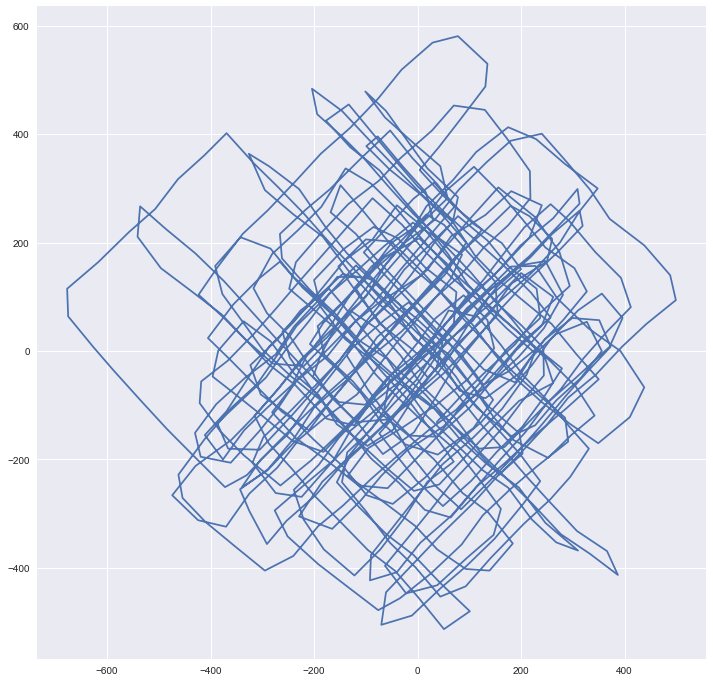

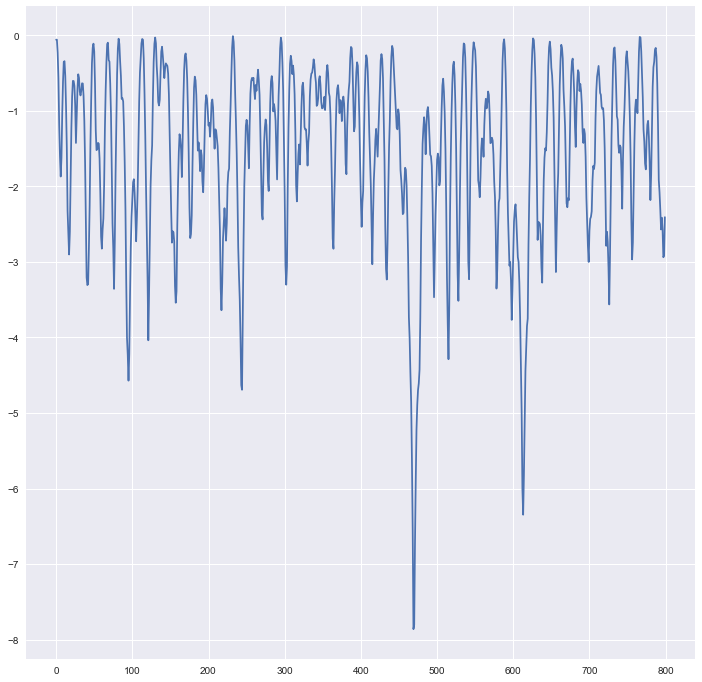

In [28]:
plt.figure(figsize=(12,12))
plt.plot(samples[:, 0], samples[:, 1])
plt.figure(figsize=(12,12))
plt.plot(np.log(energy[200:]))

Total ESS: 221.52851613651885
ESS/S: 2.7343291645083747


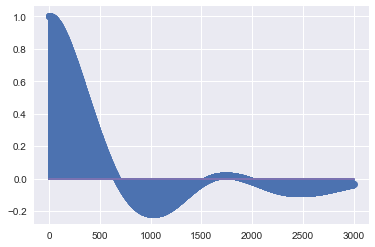

In [52]:
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
ax.stem(autocorr(np.log(energy), np.arange(0, 3000)))
ESS_E = N/(1+2*sum(autocorr(np.log(energy[int(0.2*N):]), np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtim)

In [31]:
T = 400000
thinning_ratio = 10
N = int(T/thinning_ratio)

state = np.array([100, 100, 100])#np.random.randint(-t_val*s, t_val*s, size = n)
state = state.astype("float64")
current_state = np.array([100, 100, 100])#[Decimal(x) for x in state]
print("Initial state:", current_state)

samples_c, energy_c, iteration, runtim_c = dc_sampler(n,  # Dimension of the target
                                                    n,  # Number of generators
                                                    np.repeat(1, 6),
                                                    discrete_gaussian,  # Calculates the energy of the target density
                                                    calculate_rates,  # Calculates the initial rates for the problem
                                                    local_rates,  # Updates the rate after a flip has been carried out
                                                    apply_gen,  # Applies the generator to the state
                                                    current_state, T, thinning_ratio,
                                                    calc_energy=True, print_rate=100)


Initial state: [100 100 100]
Percent: [--------------------------------------->] 100%[400000.95364572]
Average jump length: [1.99914514]
Runtime: 64.19


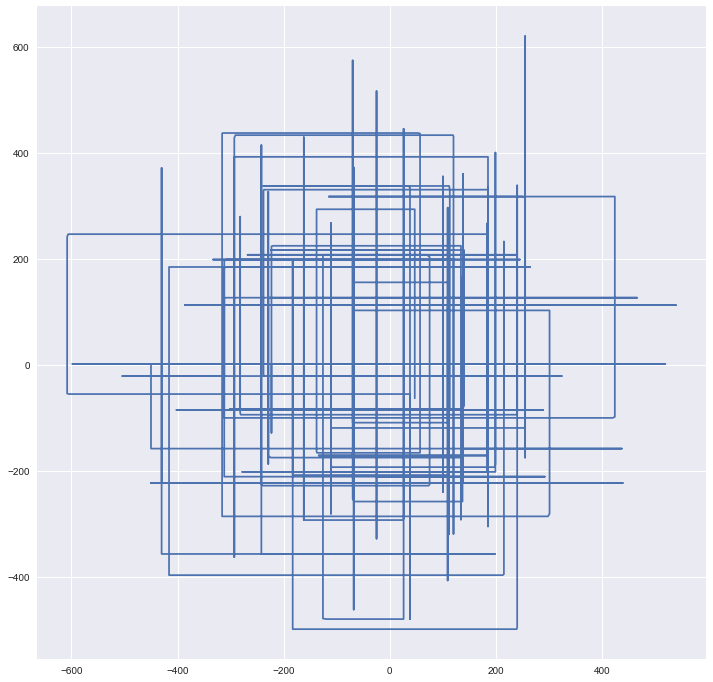

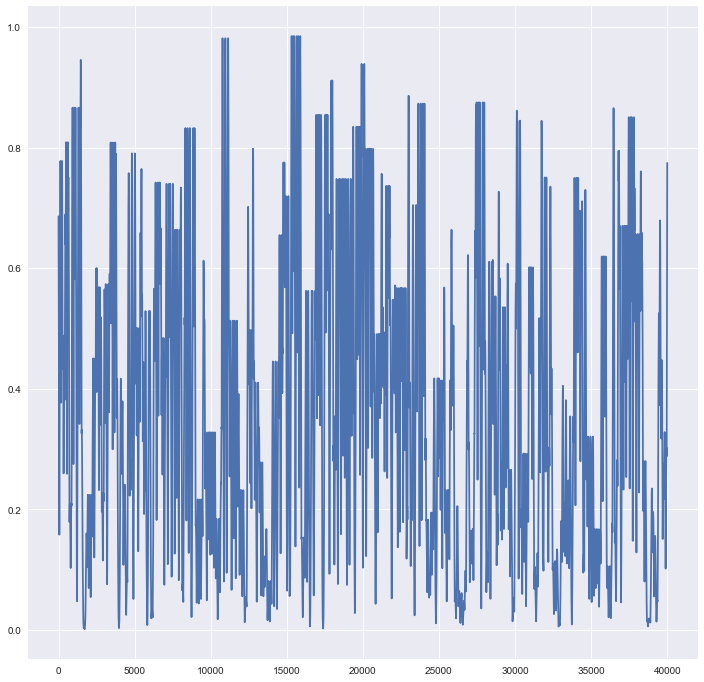

In [32]:
plt.figure(figsize=(12,12))
plt.plot(samples_c[:, 0], samples_c[:, 2])
plt.figure(figsize=(12,12))
plt.plot(energy_c)

Total ESS: 91.02229433338591
ESS/S: 1.4181220045557583


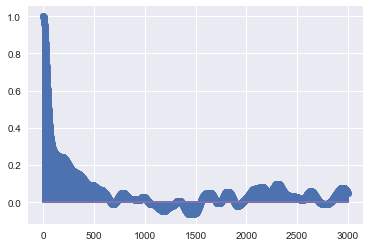

In [33]:
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
ax.stem(autocorr(energy_c, np.arange(0, 3000)))
ESS_E = N/(1+2*sum(autocorr(energy_c[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtim_c)

In [23]:
from zanella_higher_order_class import hz_sampler

def calculate_rates_saw(x, theta=0, jump_rates=0, gen_id=0):
    forward_rates = []
    backward_rates = []
    
    theta = []
    for i in range(len(x)):
        theta.append(1)
        
    theta_inverse = [val*-1 for val in theta]
    
    base_prop = discrete_gaussian(x)
    
    for i in range(n):
        forward_prop = discrete_gaussian(apply_gen(x, i, theta))
        backward_prop = discrete_gaussian(apply_gen(x, i, theta_inverse))
    
        forward_rates.append(balancing_function(forward_prop/base_prop))
        forward_rates.append(balancing_function(backward_prop/base_prop))
        
    return np.array(forward_rates).astype("float64")

def apply_gen_saw(x, gen_id):
    theta = np.empty((2*n,),int)
    theta[::2] = 1
    theta[1::2] = -1

    y = x.copy()
    y[int(np.floor(gen_id/2))] = y[int(np.floor(gen_id/2))] + theta[gen_id]
    return y


T = 50000
thinning_ratio = 0.5
N = int(T/thinning_ratio)

state = np.array([100,100,100])##np.random.randint(-t_val*s, t_val*s, size = n)
state = state.astype("float64")
current_state = [Decimal(x) for x in state]

samples_z, energy_z, iteration_z, runtime_z = hz_sampler(n, 2*n,
                                                              energy_function=discrete_gaussian,
                                                              calculate_rates=calculate_rates_saw,
                                                              update_rates=calculate_rates_saw,
                                                              apply_generator=apply_gen_saw,
                                                              current_state=current_state,
                                                              target_time=T,
                                                              thin_rate=thinning_ratio)

Percent: [>                                       ] 2%

KeyboardInterrupt: 

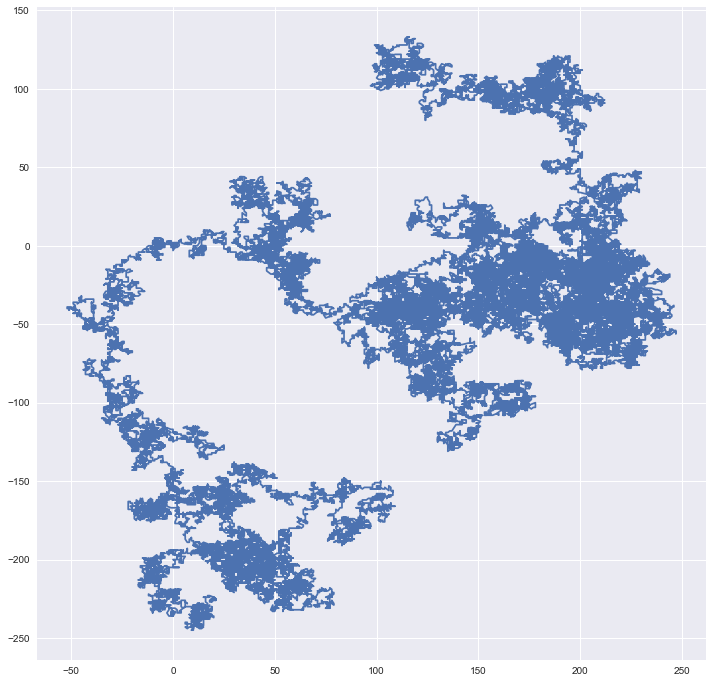

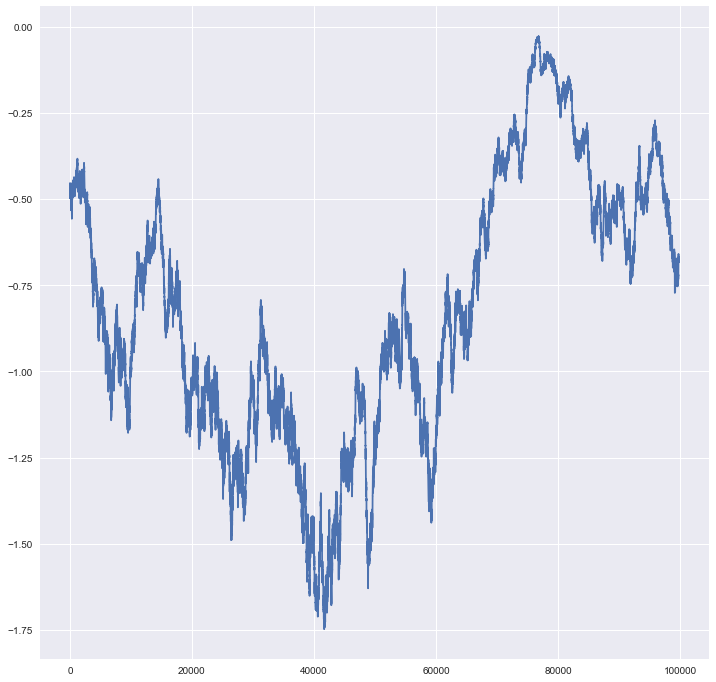

In [12]:
plt.figure(figsize=(12,12))
plt.plot(samples_z[:, 0], samples_z[:, 1])
plt.figure(figsize=(12,12))
plt.plot(np.log(energy_z[200:]))

Total ESS: 51.45772236182677
ESS/S: 0.7273064150959998


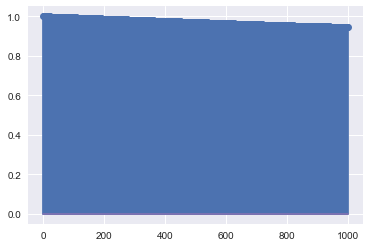

In [13]:
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
ax.stem(autocorr(np.log(energy_z[int(0.2*N):]), np.arange(0, 1000)))
ESS_E = N/(1+2*sum(autocorr(np.log(energy_z[int(0.2*N):]), np.arange(0, 1000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime_z)

(-40, 3)

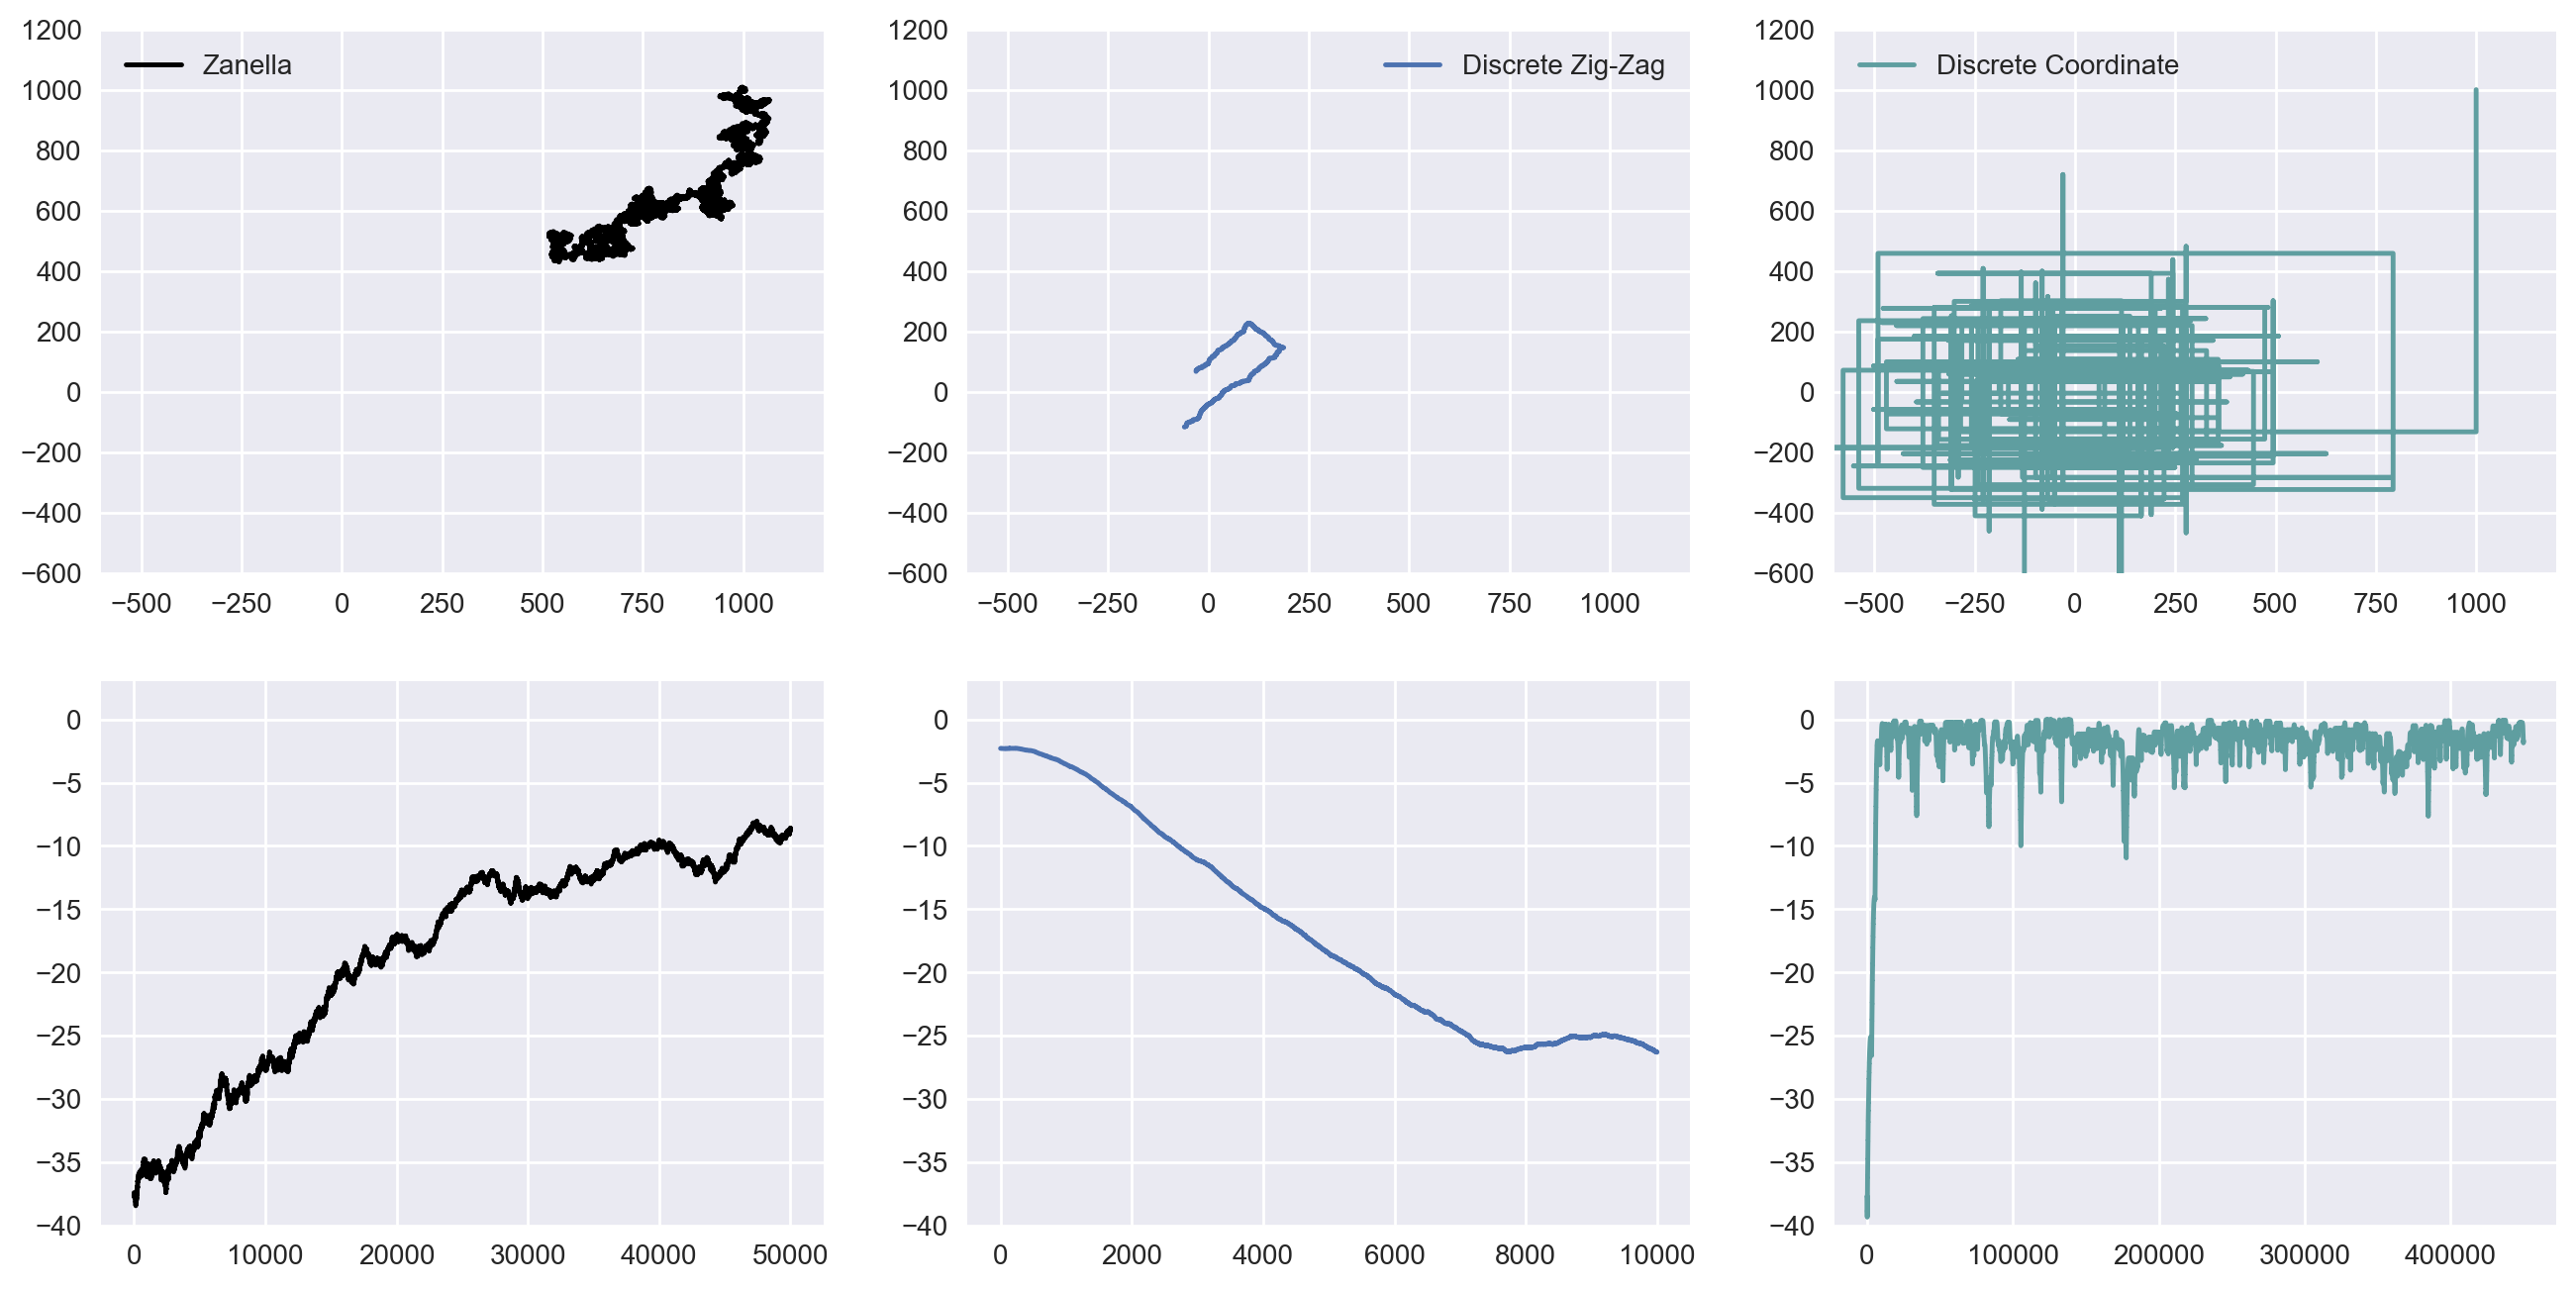

In [29]:
fig = plt.figure(figsize=(16, 8), dpi=200)

ax1 = plt.subplot(231)
ax1.plot(samples_z[:, 0], samples_z[:, 1], color="black", label="Zanella")
ax1.set_ylim(-600, 1200)
ax1.set_xlim(-600, 1200)
ax1.legend()

ax2 = plt.subplot(232)
ax2.plot(samples[:, 0], samples[:, 1], label="Discrete Zig-Zag")
ax2.set_ylim(-600, 1200)
ax2.set_xlim(-600, 1200)
ax2.legend()

ax3 = plt.subplot(233)
ax3.plot(samples_c[:, 0], samples_c[:, 1], color="cadetblue", label="Discrete Coordinate")
ax3.set_ylim(-600, 1200)
ax3.set_xlim(-600, 1200)
ax3.legend()

ax4 = plt.subplot(234)
ax4.plot(np.log(energy_z), color="black")
ax4.set_ylim(-40, 3)

ax5 = plt.subplot(235)
ax5.plot(np.log(energy))
ax5.set_ylim(-40, 3)

ax6 = plt.subplot(236)
ax6.plot(np.log(energy_c), color="cadetblue")
ax6.set_ylim(-40, 3)